# DUSTBUSTERS School
### Image Analysis - the symmetric rings of AS209
#### jpw 5/4/2022

In [1]:
import os, sys, time           
import numpy as np             
from astropy.io import fits      
import urllib.request          
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)
from scipy.interpolate import interp1d, interp2d

%matplotlib inline                

In [2]:
# set up plot parameters
import matplotlib as mpl
mpl.rc('xtick.major', size=5, pad=3, width=2)
mpl.rc('ytick.major', size=5, pad=3, width=2)
mpl.rc('xtick.minor', size=2, pad=3, width=2)
mpl.rc('ytick.minor', size=2, pad=3, width=2)
mpl.rc('axes', linewidth=2, labelsize=14, titlesize=18)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', markersize=5)
mpl.rc('font', size=12)
cmap = 'magma'

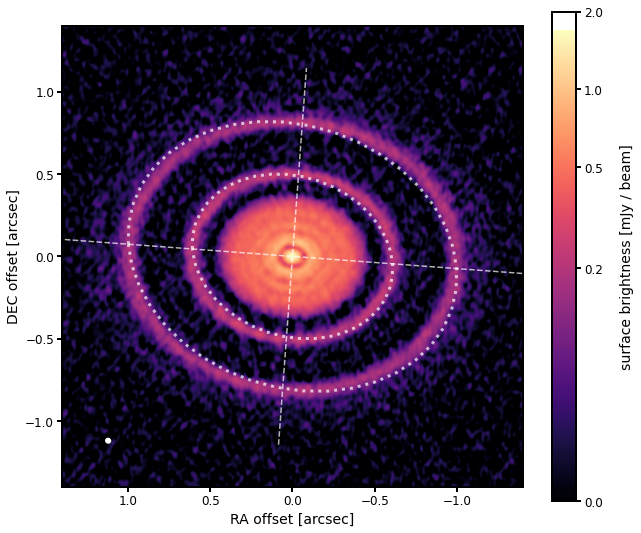

In [12]:
# disk target name
disk_name = 'AS209'

# geometric properties (from Huang et al. 2018 DSHARP II)
offRA, offDEC = +0.0019, -0.0025
incl, PA = 34.97, 85.76
#PA = 89   # eyeball fit to outer ring
#incl = 30 # eyeball fit to make residuals smaller at the end (doesn't work)
inclr, PAr = np.radians(incl), np.radians(PA)
rout = 1.4

# load the .FITS file contents
data = fits.open('data/AS209_continuum.fits')
image = 1e3 * np.squeeze(data[0].data)
header = data[0].header

# parse coordinate frame indices into physical numbers
nx, ny = header['NAXIS1'], header['NAXIS2']
RA = header['CRVAL1'] + header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1))
DEC = header['CRVAL2'] + header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1))
RAo, DECo = 3600 * (RA - header['CRVAL1']), 3600 * (DEC - header['CRVAL2'])
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
freq = header['CRVAL3']

# beam parameters 
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

# image setups
im_bounds = (RAo_shift.max(), RAo_shift.min(), DECo_shift.min(), DECo_shift.max())
dRA_lims, dDEC_lims = [rout, -rout], [-rout, rout]

# intensity limits, and stretch
vmin, vmax = 0.0, 1.7    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch(10))

# image plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

# minor and major axes
rmaj = np.linspace(-rout, rout, 2)
ax.plot(rmaj * np.sin(PAr), rmaj * np.cos(PAr), '--w', alpha=0.7)
ax.plot(rmaj * np.cos(inclr) * np.sin(PAr - 0.5*np.pi), 
        rmaj * np.cos(inclr) * np.cos(PAr - 0.5*np.pi), '--w', alpha=0.7)

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

# plot an eyeball fit ellipse to the outer ring
ring = 1.0   # semi-major axis in arcsec
theta = np.arange(41)*np.pi/20
yring = ring * np.cos(theta)
xring = ring * np.sin(theta) * np.cos(inclr)
ax.plot(xring*np.cos(PAr)+yring*np.sin(PAr), xring*np.sin(PAr)+yring*np.cos(PAr), ':w', lw=3, alpha=0.7)

# middle ring
ring = 0.61   # semi-major axis in arcsec
yring = ring * np.cos(theta)
xring = ring * np.sin(theta) * np.cos(inclr)
ax.plot(xring*np.cos(PAr)+yring*np.sin(PAr), xring*np.sin(PAr)+yring*np.cos(PAr), ':w', lw=3, alpha=0.7)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [13]:
fig.savefig('AS209_image.pdf')

## Derotated, deprojected Map

In [14]:
# function to (linearly) interpolate the map
f = interp2d(RAo_shift, DECo_shift, image)

# deprojected array coordinates from -1.5 to 1.5 arcsec with same grid step size as sky image
disk_delt = 3600 * header['CDELT2']
nxd = nyd = 1001
i0 = nxd // 2
j0 = nyd // 2
# note the convention to make the xaxis increase to the left
xdisk = (np.arange(nxd)-i0)*(-disk_delt)
ydisk = (np.arange(nyd)-j0)*disk_delt
image_deproj = np.zeros((nyd, nxd))

# brute force pixel by pixel calculation through loops is slow...
for j in range(nyd):
    for i in range(nxd):
        # apply the inverse transformation to get to sky coordinates
        dra  = np.cos(PAr)*xdisk[i]*np.cos(inclr) + np.sin(PAr)*ydisk[j]
        ddec = -np.sin(PAr)*xdisk[i]*np.cos(inclr) + np.cos(PAr)*ydisk[j]
        image_deproj[j,i] = f(dra, ddec)

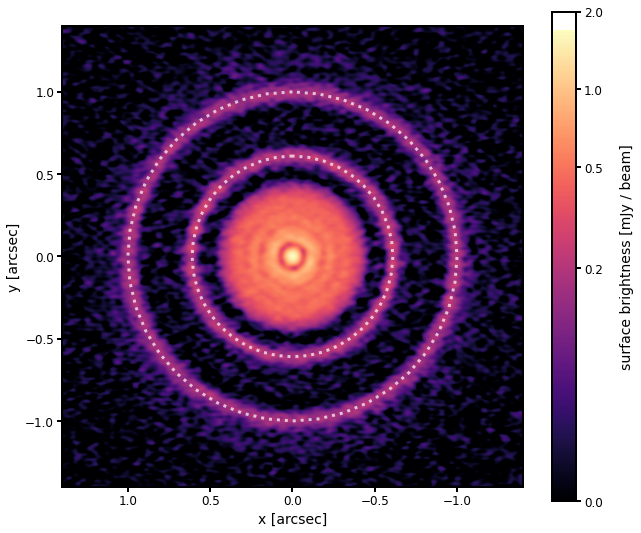

In [15]:
# plot the deprojected map - the rings should look like circles

deproj_bounds = (xdisk.max(), xdisk.min(), ydisk.min(), ydisk.max())
xdisk_lims, ydisk_lims = [rout, -rout], [-rout, rout]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image_deproj, origin='lower', cmap=cmap, extent=deproj_bounds, norm=norm, aspect='equal')

ax.set_xlim(xdisk_lims)
ax.set_ylim(ydisk_lims)
ax.set_xlabel('x [arcsec]')
ax.set_ylabel('y [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# check that the scaling is correct in the disk frame
ring = 1.0   # semi-major axis in arcsec
theta = np.arange(41)*np.pi/20
yring = ring * np.cos(theta)
xring = ring * np.sin(theta)
ax.plot(xring, yring, ':w', lw=3, alpha=0.7)

ring = 0.61
yring = ring * np.cos(theta)
xring = ring * np.sin(theta)
ax.plot(xring, yring, ':w', lw=3, alpha=0.7)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [16]:
fig.savefig('AS209_deprojected.pdf')

## Deprojected Radius-Azimuth Map amd Radial Profile

In [17]:
f = interp2d(xdisk, ydisk, image_deproj, kind='cubic')

# polar coordinates
r = np.arange(disk_delt, 1.5*rout, disk_delt)
theta = np.linspace(-180, 180, 181)
image_polar = np.zeros((theta.size, r.size))

for j in range(theta.size):
    for i in range(r.size):
        # apply the inverse transformation to get to disk coordinates
        xd = r[i] * np.cos(np.radians(theta[j]))
        yd = r[i] * np.sin(np.radians(theta[j]))
        image_polar[j,i] = f(xd, yd)

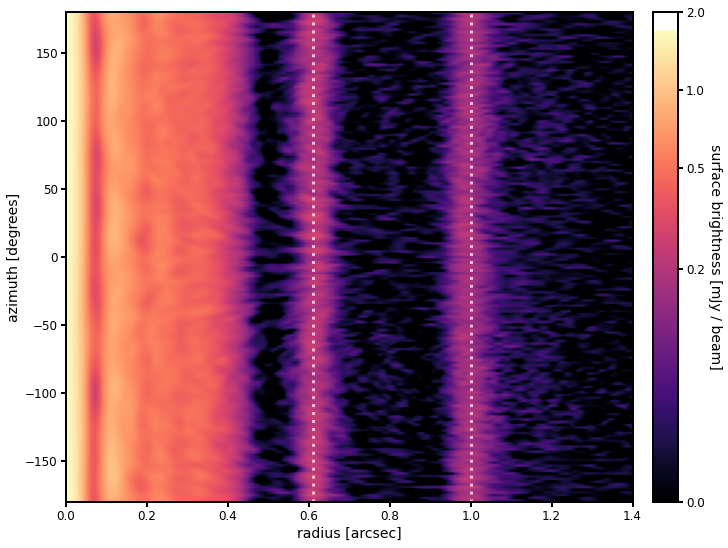

In [18]:
# image setups
polar_bounds = (r.min(), r.max(), theta.min(), theta.max())
r_lims = [0, rout]
theta_lims = [theta.min(), theta.max()]      

# set up and plot the images on the specified scale
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(image_polar, origin='lower', cmap=cmap, extent=polar_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(theta_lims)
#ax.grid()
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.03)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

# show the location of the rings
for ring in [1.0, 0.61]:
    ax.plot([ring,ring], [-180,180], ':w', lw=3, alpha=0.7)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [19]:
fig.savefig('AS209_polar.pdf')

Text(0, 0.5, '$T_b \\,\\,$ [K]')

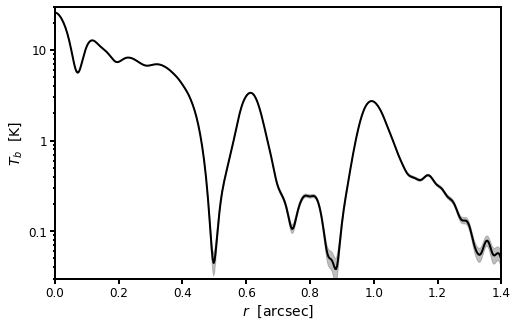

In [20]:
# plot the radial profile in brightness temperature (R-J limit)
kB_, c_ = 1.38064852e-16, 2.99792e10

# convert radial profile from mJy/beam to brightness temperatures (R-J limit)
Tb = c_**2 * 1e-26 * np.mean(image_polar, axis=0) / beam_area / (2 * kB_ * freq**2)
# error in the mean, assuming the azimuth pixels are independent (which they are probably not, especially at small r)
Tb_err = c_**2 * 1e-26 * np.std(image_polar, axis=0)/np.sqrt(image_polar.shape[1]) / beam_area / (2 * kB_ * freq**2)

# to avoid the covariance between pixels, use the median (this is somewhat noisier)
# convert radial profile from mJy/beam to brightness temperatures (R-J limit)
#Tb = c_**2 * 1e-26 * np.median(image_polar, axis=0) / beam_area / (2 * kB_ * freq**2)
# standard error in the median
#Tb_err = c_**2 * 1e-26 * 1.2533*np.std(image_polar, axis=0)/np.sqrt(image_polar.shape[1]) / beam_area / (2 * kB_ * freq**2)


fig, ax = plt.subplots(figsize=(8,5))
ax.fill_between(r, Tb-Tb_err, Tb+Tb_err, color='gray', alpha=0.5)
ax.plot(r, Tb, 'k', lw=2, label='Data')
ax.set_xlim([0, rout])
ax.set_ylim([0.03, 30])
ax.set_yscale('log')
ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels(['0.1', '1', '10'])
ax.set_xlabel('$r \,\,$ [arcsec]')
ax.set_ylabel('$T_b \,\,$ [K]')
#ax.legend()

In [16]:
# save profile as a plot and ascii text file
fig.savefig('AS209_radial_profile.pdf')
with open('AS209_radial_profile.txt', 'w') as f:
    f.write('# r[asec] Tb[K]   Tb_err[K]\n')
    for i in range(r.size):
        f.write(f' {r[i]:6.3f}   {Tb[i]:6.3f} {Tb_err[i]:6.3f}\n')
f.close

<function TextIOWrapper.close()>